# Bestmögliches Regressionsmodell - kaggle-Contest

Challenge: cml1/3Db Immobilienrechner <br/>
Team: Alexander Shanmugam, Si Ben Tran, Gabriel Torrez Gamez, Haris Alic <br/>
Aufgabe: 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vegleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.


---

# Module importieren

Hier in diesem Abschnitt importieren wir die wichtigisten Module, die wir für die weitere Bearbeitung unserer Machine Learning Modelle benötigen, um die Vorhersage des Immobilienpreises zu erstellen.


In [1]:
# Basic Data Science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules

# pipeline
from sklearn.pipeline import make_pipeline

# KNNimputer
from sklearn.impute import KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# neighbors
from sklearn.neighbors import KNeighborsRegressor

# tree
from sklearn.tree import DecisionTreeRegressor

# ensemble
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor,
)

# model_selection
from sklearn.model_selection import train_test_split, GridSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error

# xgboost
from xgboost import XGBRegressor


---

# Daten importieren

Hier in diesem Abschnitt importieren wir die Immobilien Daten, die uns Fernando zur Verfügung gestellt hat.

raw_data ist der vollständige Datensatz der Kompetition

raw_data_kaggle ist der Datensatz der Kompetition


In [2]:
# url and relative path for the data

rel_path = "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean_gde.csv"
# Clean data einlesen
rel_path_kaggle = "https://github.com/Immobilienrechner-Challenge/data/blob/main/kaggle_gde_cleaned.parquet?raw=true"

# Read data into pandas dataframe
raw_data = pd.read_csv(rel_path, index_col=0, low_memory=False)
raw_data_kaggle = pd.read_parquet(rel_path_kaggle)


In [3]:
raw_data.shape


(13067, 62)

In [4]:
raw_data_kaggle.shape


(24566, 61)

---

# Daten vorbereiten

Hier werden die Daten vorbereitet, indem wir die Daten in Trainings- und Validierungsdaten aufteilen.


In [5]:
# drop the columns municipality, street, street_nr and zip_code
data = raw_data.drop(
    columns=["municipality", "street", "street_nr", "zip_code", "availability"]
)

# drop rows where price is nan
data = data.dropna(subset=["price"])

# count number of dtypes
print("Number of dtypes:\n", data.dtypes.value_counts())

# print dtypes object columns
print("Dtypes object columns:", data.select_dtypes(include="object").columns)

# make one hot encoding for the columns objects
data = pd.get_dummies(data, columns=["canton", "type"])

# print shape of df
print("Shape of df:", data.shape)

# get top 10 cols with highest NA values
print(
    "Top 10 cols with highest NA values:",
    data.isna().sum().sort_values(ascending=False).head(30),
)


Number of dtypes:
 float64    54
object      2
int64       1
dtype: int64
Dtypes object columns: Index(['canton', 'type'], dtype='object')
Shape of df: (12052, 101)
Top 10 cols with highest NA values: floor_space            9356
plot_area              7710
floor                  6845
gde_politics_pda       5611
gde_politics_bdp       4489
gde_politics_evp       3442
gde_politics_rights    2386
gde_politics_glp       1922
living_space            879
rooms                   425
gde_politics_gps        411
gde_politics_cvp        283
gde_politics_fdp        126
gde_politics_sp          79
gde_politics_svp         47
canton_TG                 0
canton_NW                 0
canton_NE                 0
canton_LU                 0
canton_JU                 0
canton_GR                 0
canton_GL                 0
canton_GE                 0
canton_FR                 0
canton_BS                 0
canton_OW                 0
canton_SG                 0
canton_SH                 0
canton_SO      

Hier sind die Kaggle Test Daten. Die Prediction dieser Daten müssen wir einreichen.


In [6]:
# drop the columns municipality, street, street_nr and zip_code
data_kaggle = raw_data_kaggle.drop(
    columns=["municipality", "street", "street_nr", "zip_code", "availability"]
)

# count number of dtypes
print("Number of dtypes:\n", data_kaggle.dtypes.value_counts())

# print dtypes object columns
print("Dtypes object columns:", data_kaggle.select_dtypes(include="object").columns)

# make one hot encoding for the columns objects
data_kaggle = pd.get_dummies(data_kaggle, columns=["canton", "type"])

# print shape of df
print("Shape of df_kaggle:", data_kaggle.shape)

# get top 10 cols with highest NA values
print(
    "Top 10 cols with highest NA values:",
    data_kaggle.isna().sum().sort_values(ascending=False).head(30),
)


Number of dtypes:
 float64     53
category     1
object       1
int64        1
dtype: int64
Dtypes object columns: Index(['type'], dtype='object')
Shape of df_kaggle: (24566, 99)
Top 10 cols with highest NA values: floor_space            22141
plot_area              20088
floor                  19184
gde_politics_pda       12037
gde_politics_bdp        8755
gde_politics_evp        7472
gde_politics_rights     4673
gde_politics_glp        3390
living_space            2144
gde_politics_gps        1151
rooms                   1001
gde_politics_cvp         637
gde_politics_fdp         383
gde_politics_sp          225
gde_politics_svp         158
canton_OW                  0
canton_SG                  0
canton_SH                  0
canton_NW                  0
canton_SZ                  0
canton_NE                  0
canton_LU                  0
canton_JU                  0
canton_GR                  0
canton_GL                  0
canton_GE                  0
canton_FR                  0
ca

## Daten reparieren


In [7]:
# modify matrix data_kaggle to have the same columns
diff_cols = list(set(data.columns) - set(data_kaggle.columns) - {"price"})
data_kaggle[diff_cols] = 0

# modify matrix data to have the same columns
diff_cols2 = list(set(data_kaggle.columns) - set(data.columns))
data[diff_cols2] = 0


## Daten splitten


In [8]:
# splitting dataframe into train and test set
train, val = train_test_split(data, test_size=0.2, random_state=42)

# splitting train and val into X and y
X_train = train.drop("price", axis=1)
y_train = train["price"]

X_val = val.drop("price", axis=1)
y_val = val["price"]

# creating a split with full data
X = data.drop("price", axis=1)
y = data["price"]

# print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)


Shape of X_train:  (9641, 101)
Shape of y_train:  (9641,)
Shape of X_val:  (2411, 101)
Shape of y_val:  (2411,)
Shape of X:  (12052, 101)
Shape of y:  (12052,)


### Vergleich Kaggle

Hier zeigen wir zum Vergleich die Dimensionen des Kaggle Datensatz


In [9]:
# print shape of X
print("Shape of data_kaggle: ", data_kaggle.shape)


Shape of data_kaggle:  (24566, 101)


## Datenimputation


In [10]:
cols = X_train.columns

X_train = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(X_train[cols]), columns=X_train.columns
)
print("X_train transformed")

X_val = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(X_val[cols]), columns=X_val.columns
)
print("X_val transformed")

data_kaggle = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(data_kaggle[cols]),
    columns=data_kaggle.columns,
)
print("data_kaggle transformed")


X_train transformed
X_val transformed
data_kaggle transformed


## Daten standardisieren


In [11]:
cols = X_train.columns
scaler = StandardScaler().fit(X_train[cols])
# scaler = MinMaxScaler().fit(X_train[cols])
# scaler = RobustScaler().fit(X_train[cols])

X_train = pd.DataFrame(scaler.transform(X_train[cols]), columns=cols)
X_val = pd.DataFrame(scaler.transform(X_val[cols]), columns=cols)
X_kaggle = pd.DataFrame(scaler.transform(data_kaggle[cols]), columns=cols)


---

# Modell 1 - Multiple Lineare Model

Modell 1 ist ein multiples lineares Modell, welches wir als Benchmark für die weiteren Modelle verwenden werden. Wir haben uns für dieses Modell entschieden, da es ein einfaches Modell ist, welches wir schnell erstellen können und es uns ermöglicht, die Vorhersage des Preises zu erstellen.

[fernando] -> Gewichtung der Features


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'fit_intercept': True, 'positive': True}
Mean absolute percentage error: 0.5273050495564385


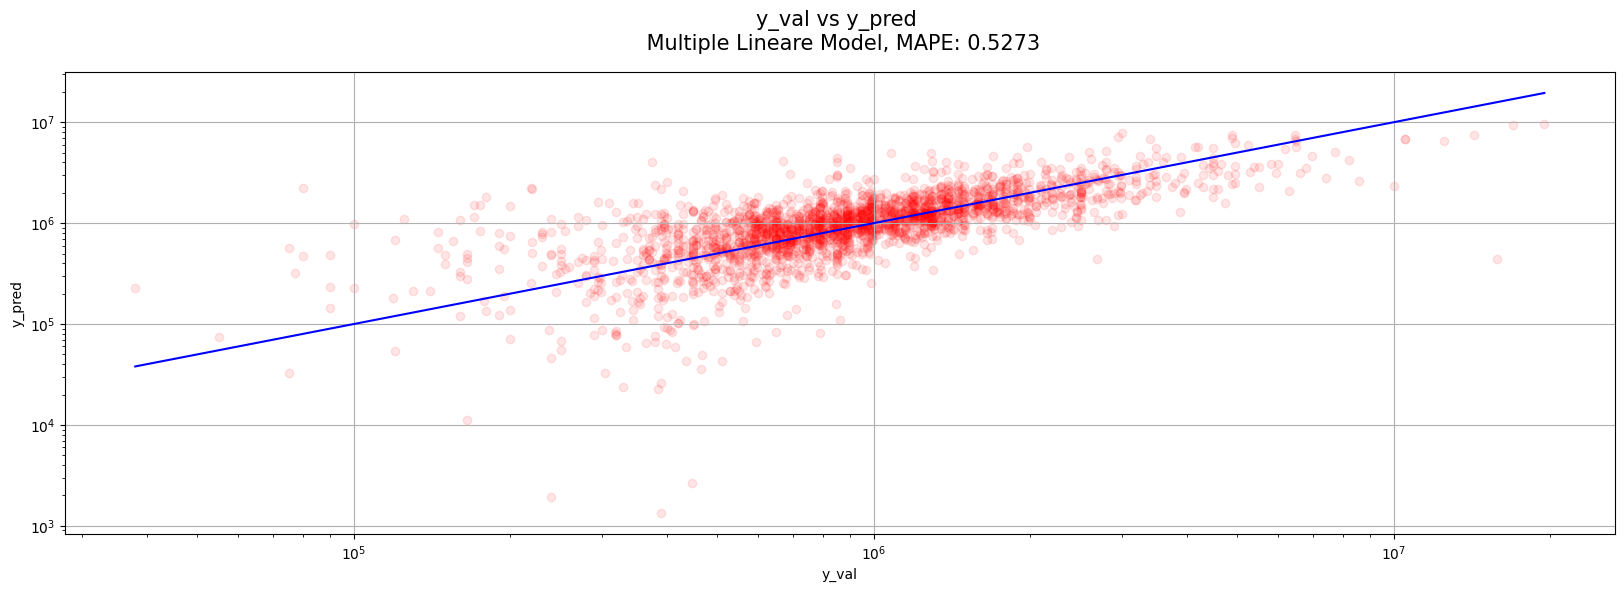

In [12]:
# make a linear regression function with gridsearchcv
def linear_regression(X_train, y_train, X_val, y_val, cv=5, verbose=1):
    """
    Function to make a linear regression model with gridsearchcv.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Target values.
    X_val : array-like
        Test data.
    y_val : array-like
        Target values.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best linear regression fitted model
    """

    # create a linear regression model
    lin_reg = LinearRegression()

    # create a dictionary with the parameters
    params = {
        "fit_intercept": [True, False],
        "positive": [True, False],
    }

    # create a gridsearchcv model
    lin_reg_grid = GridSearchCV(
        lin_reg,
        params,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    lin_reg_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best params:", lin_reg_grid.best_params_)

    # make predictions
    y_pred_lin = lin_reg_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_lin_reg = mean_absolute_percentage_error(y_val, y_pred_lin)
    print("Mean absolute percentage error:", mape_lin_reg)

    # create y_val and y_pred plot
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_lin, c="red", alpha=0.1)
    plot_lin = np.linspace(np.min(y_val), np.max(y_val), 2)
    plt.plot(plot_lin, plot_lin, c="blue")
    plt.grid()
    plt.xlabel("y_val")
    plt.ylabel("y_pred")
    plt.title(
        "y_val vs y_pred \n Multiple Lineare Model, MAPE: "
        + str(np.round(mape_lin_reg, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return lin_reg_grid


# call function linear_regression for dev data
linear_regression = linear_regression(X_train, y_train, X_val, y_val, cv=5, verbose=1)


---

# Modell 2 - Lasso Regression

Modell 2 ist ein multiples lineares Lasso Modell.


Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42, 'selection': 'cyclic'}
Mean absolute percentage error: 0.5179204032873735


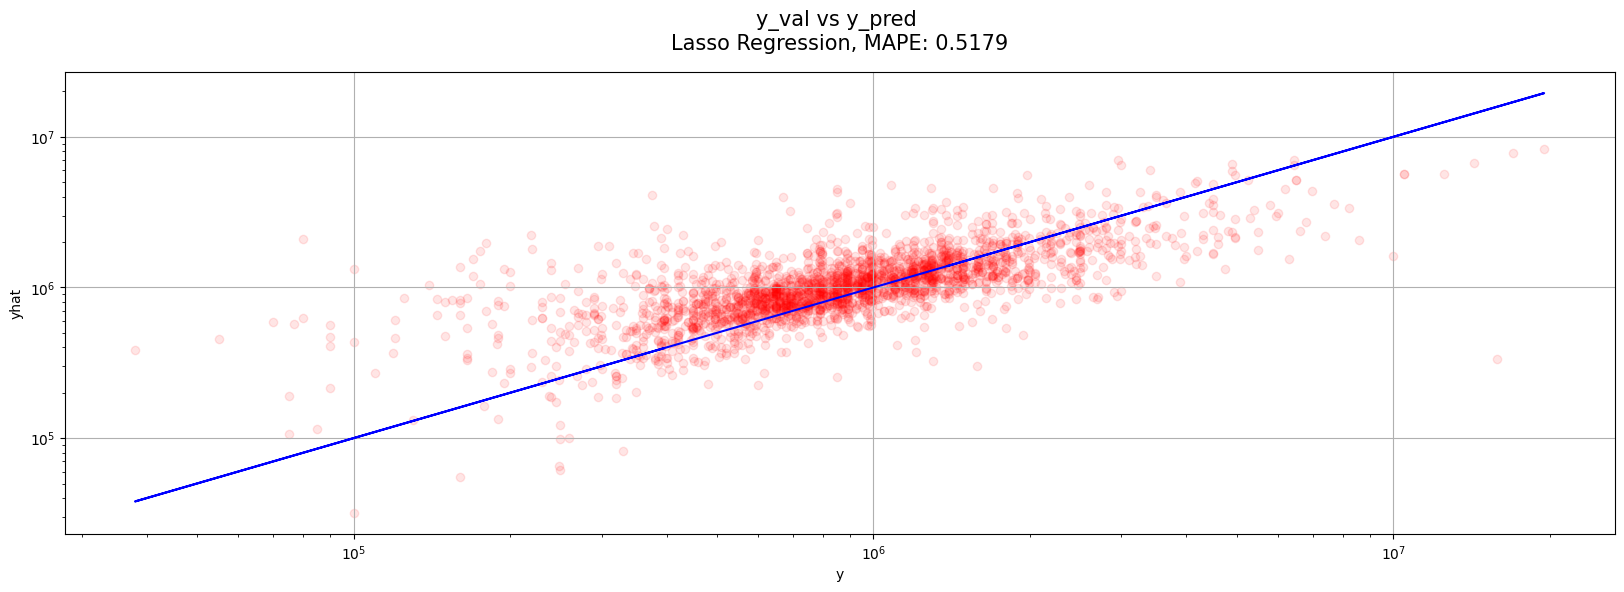

In [13]:
# make a lasso regression function with gridsearchCV
def lasso_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=[0.001, 1],
    iterations=[1000],
    cv=5,
    verbose=1,
):
    """
    This function makes a lasso regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the lasso regression.
    iterations : numpy array
        iterations for the lasso regression.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best lasso regression fitted model
    """

    # create Lasso Modell with gridsearch cv
    lasso = Lasso()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "max_iter": iterations,
        "random_state": [42],
        "positive": [True, False],
        "selection": ["random", "cyclic"],
    }

    # create gridsearchcv model
    lasso_grid = GridSearchCV(
        lasso,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    lasso_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", lasso_grid.best_params_)

    # predict the model
    y_pred_lasso = lasso_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_lasso = mean_absolute_percentage_error(y_val, y_pred_lasso)
    print("Mean absolute percentage error:", mape_lasso)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_lasso, c="red", alpha=0.1)
    plt.plot(y_val, y_val, c="blue")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nLasso Regression, MAPE: " + str(np.round(mape_lasso, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return lasso_grid


# call the function
lasso_regression = lasso_regression_gridsearchCV(
    X_train, y_train, X_val, y_val, np.logspace(5, 7, 100), [100], cv=5, verbose=1
)


Features with coef > 0: Index(['living_space', 'floor_space', 'gde_area_settlement_percentage',
       'gde_foreigners_percentage', 'gde_politics_fdp', 'gde_politics_gps',
       'canton_GE', 'canton_VD'],
      dtype='object')


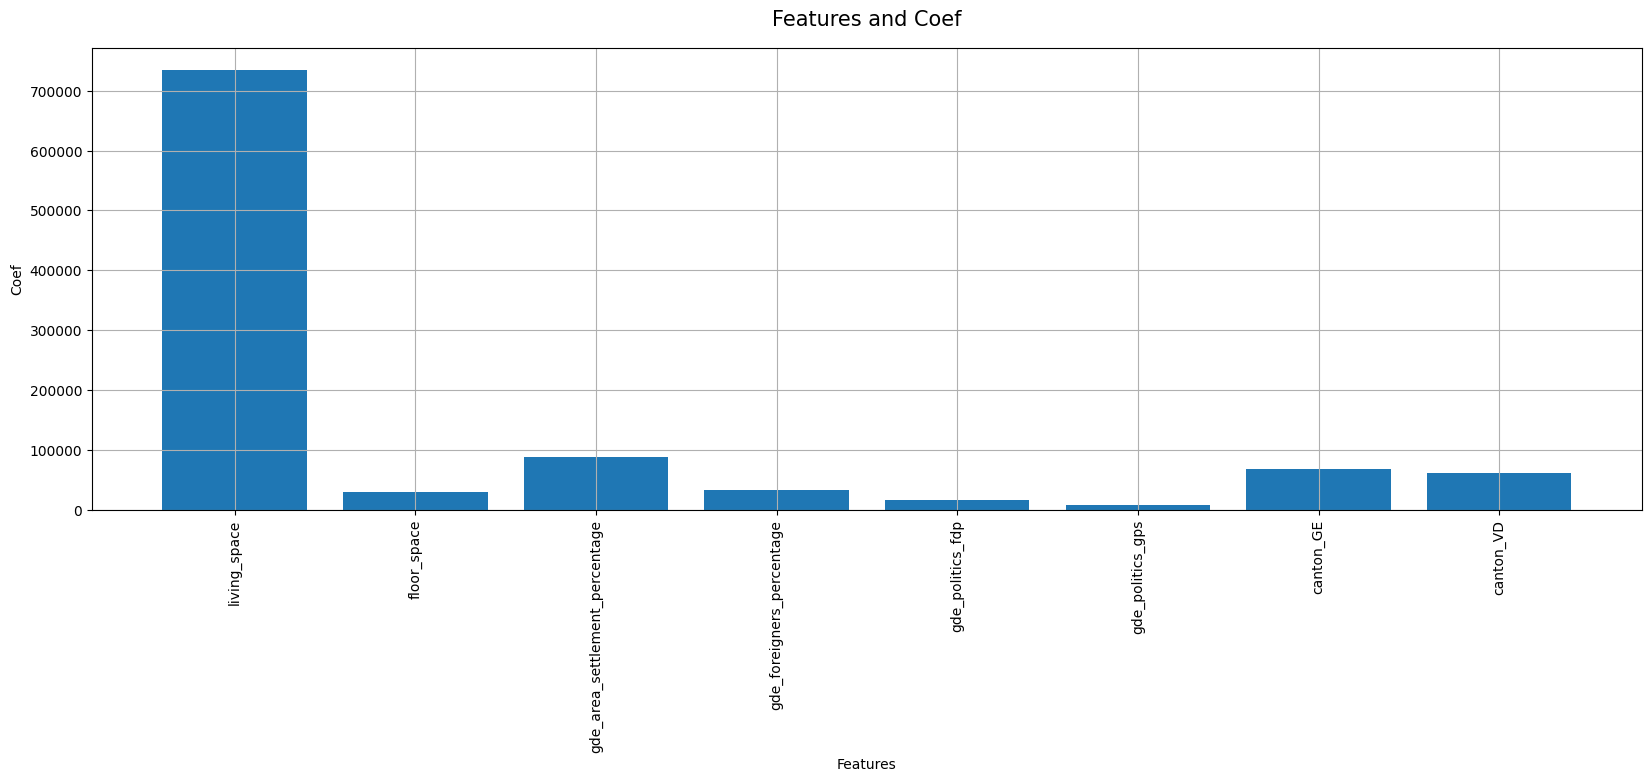

In [14]:
# get all features with coef > 0
lasso_features = X_train.columns[lasso_regression.best_estimator_.coef_ > 0]

# print the features
print("Features with coef > 0:", lasso_features)

# barplot of the features and coefs
plt.figure(figsize=(20, 6))
plt.bar(
    lasso_features,
    lasso_regression.best_estimator_.coef_[lasso_regression.best_estimator_.coef_ > 0],
)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Features")
plt.ylabel("Coef")
plt.title("Features and Coef", fontsize=15, y=1.03)
plt.show()


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': True, 'random_state': 42, 'selection': 'cyclic'}
Mean absolute percentage error: 0.5179208830142418


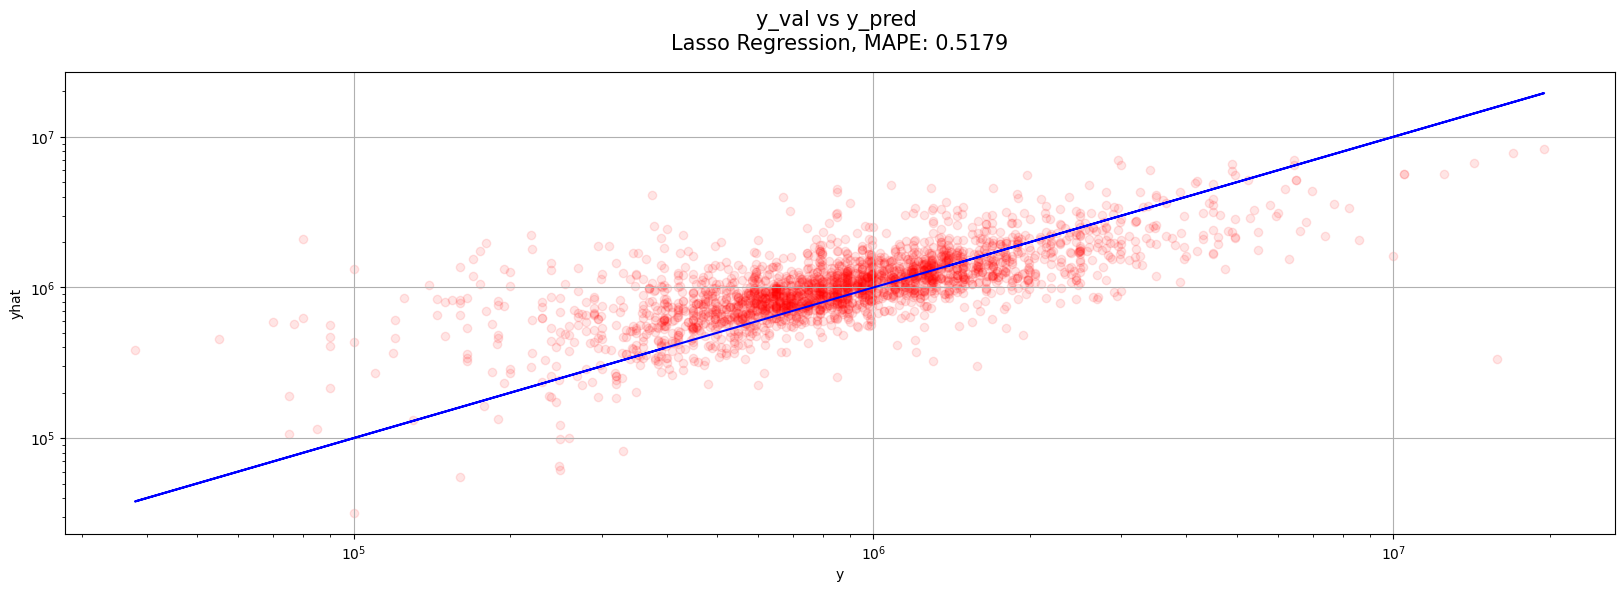

In [15]:
# call the function
lasso_regression_reduced = lasso_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    np.logspace(5, 6, 10),
    [100],
    cv=5,
    verbose=1,
)


---

# Modell 3 - Ridge Regression

Modell 3 ist ein multiples lineares Ridge Modell.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'alpha': 10000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42}
Mean absolute percentage error: 0.527759112392031


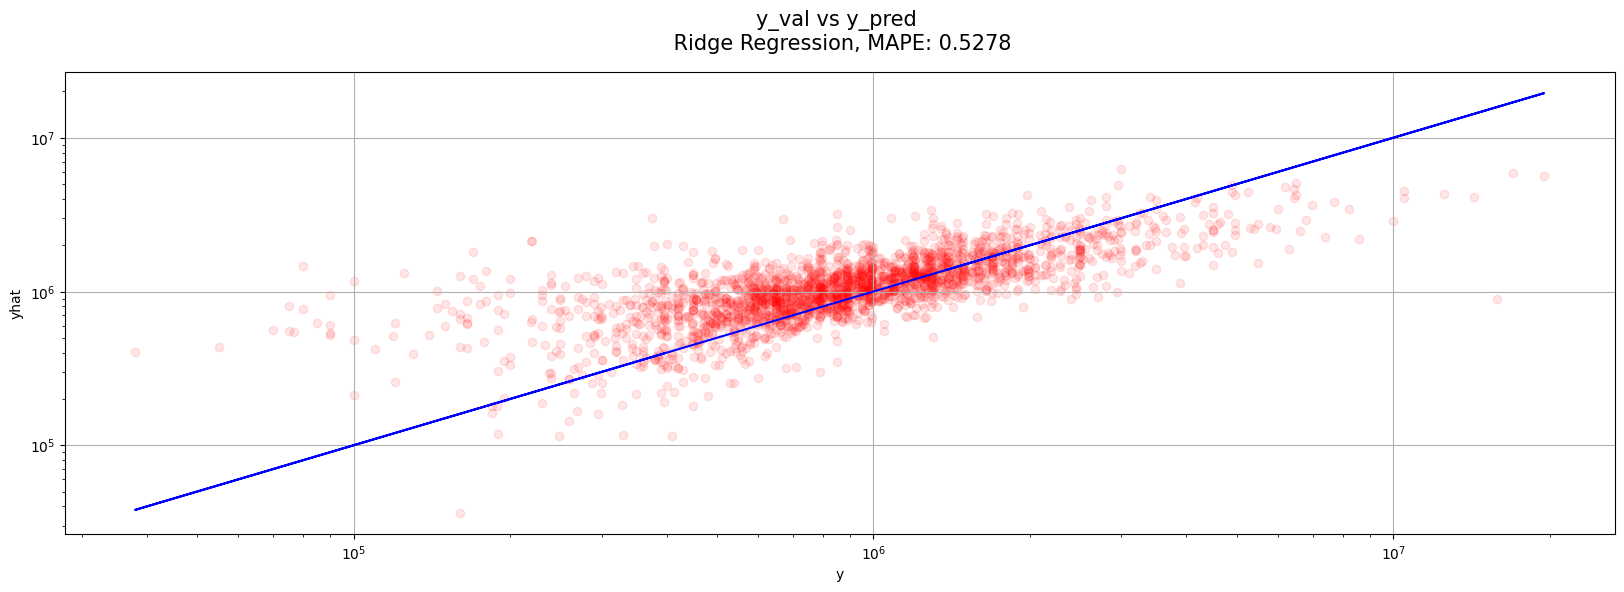

In [16]:
# make a ridge regression function with gridsearchCV
def ridge_regression_gridsearchCV(
    X_train, y_train, X_val, y_val, alphas=[1], iterations=[1000], cv=5, verbose=1
):
    """
    This function makes a ridge regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the ridge regression.
    iterations : numpy array
        iterations for the ridge regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.


    Returns
    -------
    model : object
        the best ridge regression fitted model
    """

    # create Ridge Modell with gridsearch cv
    ridge = Ridge()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "max_iter": iterations,
        "positive": [True, False],
        "random_state": [42],
    }

    # create gridsearchcv model
    ridge_grid = GridSearchCV(
        ridge,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    ridge_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", ridge_grid.best_params_)

    # predict the model
    y_pred_ridge = ridge_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_ridge = mean_absolute_percentage_error(y_val, y_pred_ridge)
    print("Mean absolute percentage error:", mape_ridge)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_ridge, c="red", alpha=0.1)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \n Ridge Regression, MAPE: " + str(np.round(mape_ridge, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return ridge_grid


# call the function
ridge_regression = ridge_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    np.logspace(4, 6, 100),
    iterations=[100],
    cv=5,
    verbose=1,
)


---

# Modell 4 - Elastic Net Regression

Modell 4 ist ein multiples lineares Elastic Net Modell.


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 100, 'positive': False, 'random_state': 42, 'selection': 'cyclic'}


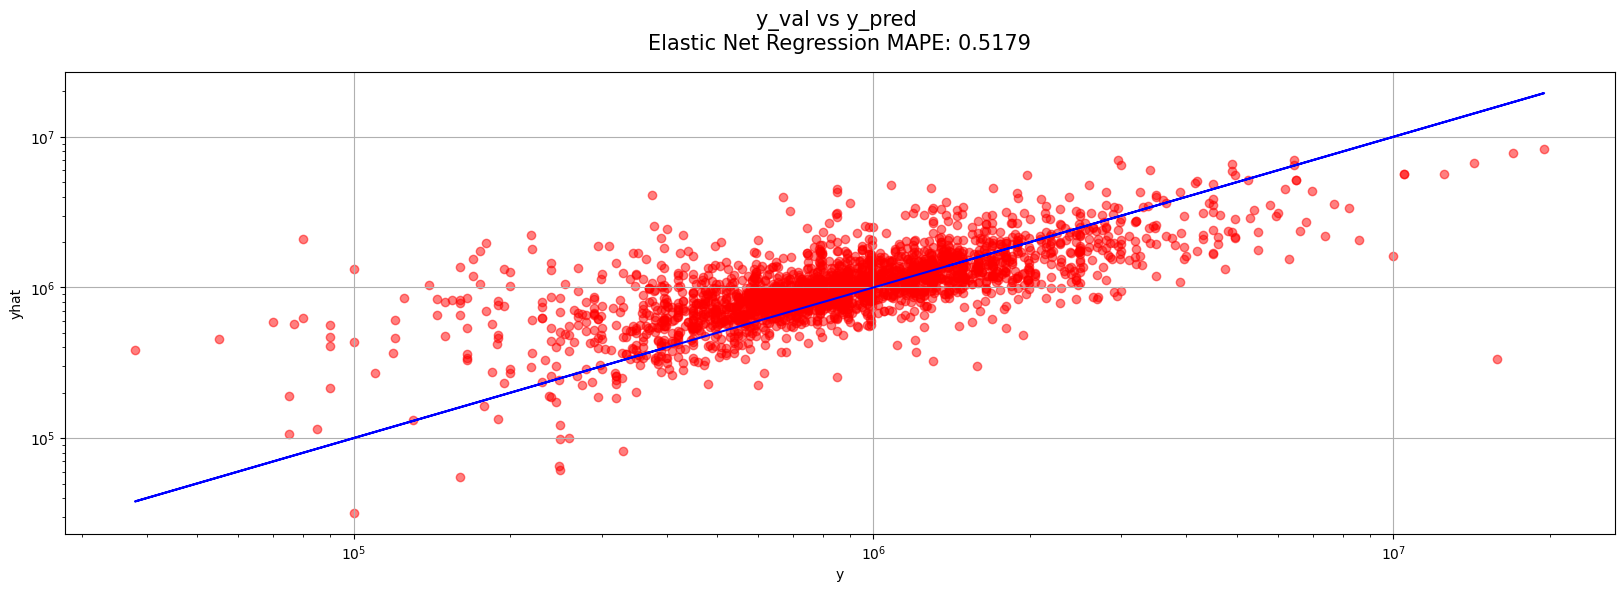

In [17]:
# make a elastic net regression function with gridsearchCV
def elastic_net_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=[1],
    l1_ratio=[0.5],
    iterations=[1000],
    cv=5,
    verbose=1,
):
    """
    This function makes a elastic net regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the elastic net regression.
    l1_ratio : numpy array
        l1_ratio for the elastic net regression.
    iterations : numpy array
        iterations for the elastic net regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best elastic net regression fitted model
    """

    # create Elastic Net Modell with gridsearch cv
    elastic_net = ElasticNet()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "l1_ratio": l1_ratio,
        "max_iter": iterations,
        "positive": [True, False],
        "random_state": [42],
        "selection": ["random", "cyclic"],
    }

    # create gridsearchcv model
    elastic_net_grid = GridSearchCV(
        elastic_net,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    elastic_net_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", elastic_net_grid.best_params_)

    # predict the model
    y_pred_elastic_net = elastic_net_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_elastic_net = mean_absolute_percentage_error(y_val, y_pred_elastic_net)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_elastic_net, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nElastic Net Regression MAPE: "
        + str(np.round(mape_elastic_net, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return elastic_net_grid


# call the function
elastic_net_regression = elastic_net_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=np.logspace(5, 6, 30),
    l1_ratio=[1],
    iterations=[100],
    cv=5,
    verbose=1,
)


---

# Modell 5 - KNN Regression

Modell 5 ist ein KNN Modell.


Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


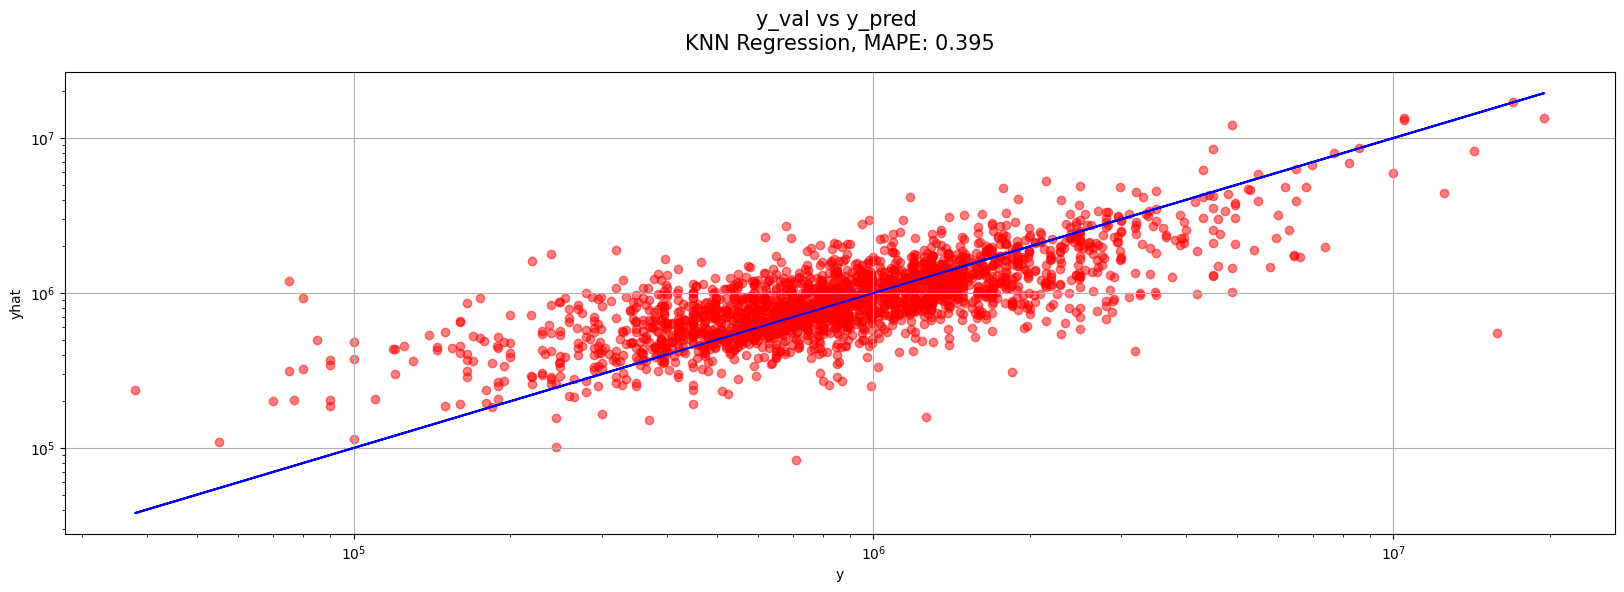

In [18]:
# make a KNN regression function with gridsearchCV
def knn_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_neighbors=[5],
    power=[1, 2],
    leaf_size=[30],
    cv=5,
    verbose=1,
):
    """
    This function makes a KNN regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    n_neighbors : numpy array
        n_neighbors for the KNN regression.
    power : numpy array
        power for the KNN regression.
    leaf_size : numpy array
        leaf_size for the KNN regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best KNN regression fitted model
    """
    # create KNN Modell with gridsearch cv
    knn = KNeighborsRegressor()

    # create parameter grid
    param_grid = {
        "n_neighbors": n_neighbors,
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": leaf_size,
        "p": power,
        "metric": ["minkowski"],
    }

    # create gridsearchcv model
    knn_grid = GridSearchCV(
        knn,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    knn_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", knn_grid.best_params_)

    # predict the model
    y_pred_knn = knn_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_knn = mean_absolute_percentage_error(y_val, y_pred_knn)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_knn, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nKNN Regression, MAPE: " + str(np.round(mape_knn, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return knn_grid


# call the function
knn_regression = knn_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_neighbors=[3],
    leaf_size=[5],
    power=[1],
    cv=4,
    verbose=1,
)


---

# Modell 6 - Decision Tree Regression

Modell 6 ist ein Decision Tree Modell.

[Feedback] -> Variable importance


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


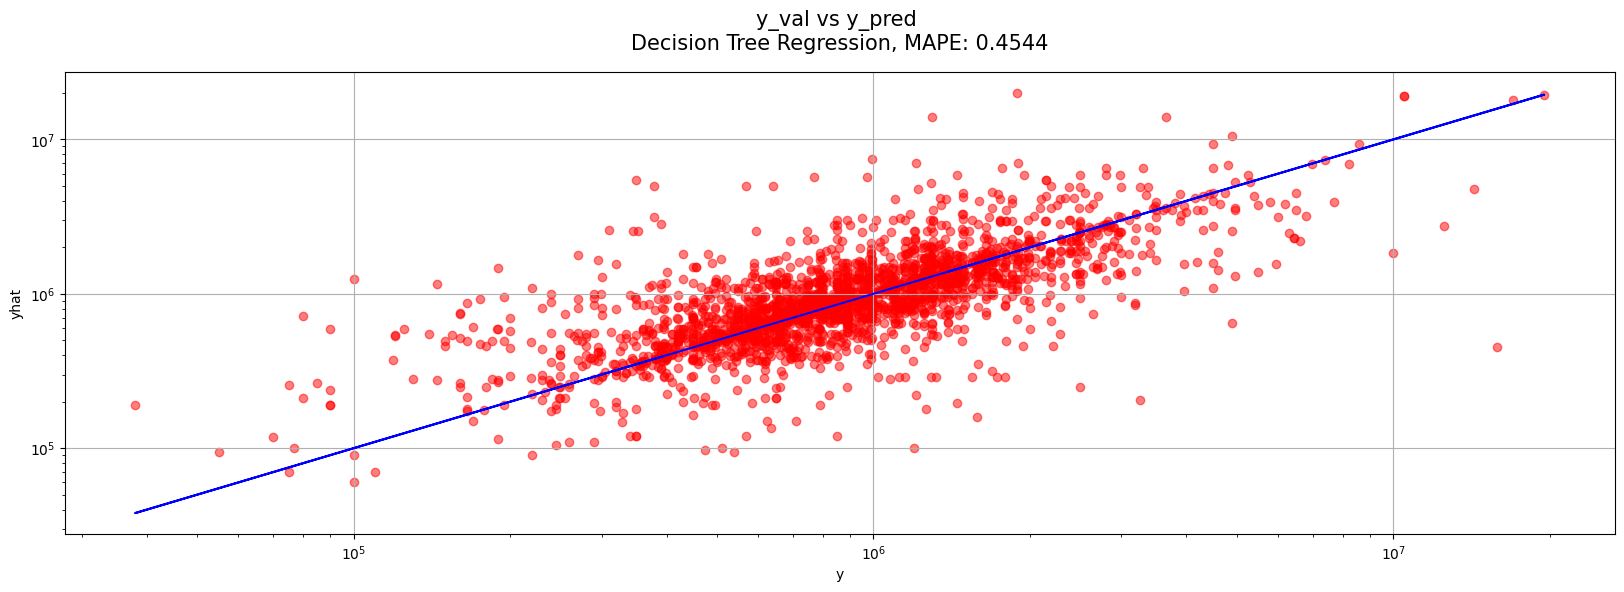

In [19]:
# make a decision Tree regression function with gridsearchCV
def decision_tree_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a decision tree regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    max_depth : numpy array
        max_depth for the decision tree regression.
    min_samples_split : numpy array
        min_samples_split for the decision tree regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the decision tree regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best decision tree regression fitted model
    """
    # create decision tree Modell with gridsearch cv
    decision_tree = DecisionTreeRegressor()

    # create parameter grid
    param_grid = {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "splitter": ["best", "random"],
        "max_features": [None, "sqrt", "log2"],
        "random_state": [42],
    }

    # create gridsearchcv model
    decision_tree_grid = GridSearchCV(
        decision_tree,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    decision_tree_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", decision_tree_grid.best_params_)

    # predict the model
    y_pred_decision_tree = decision_tree_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_decision_tree = mean_absolute_percentage_error(y_val, y_pred_decision_tree)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_decision_tree, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nDecision Tree Regression, MAPE: "
        + str(np.round(mape_decision_tree, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return decision_tree_grid


# call the function
decision_tree_regression = decision_tree_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


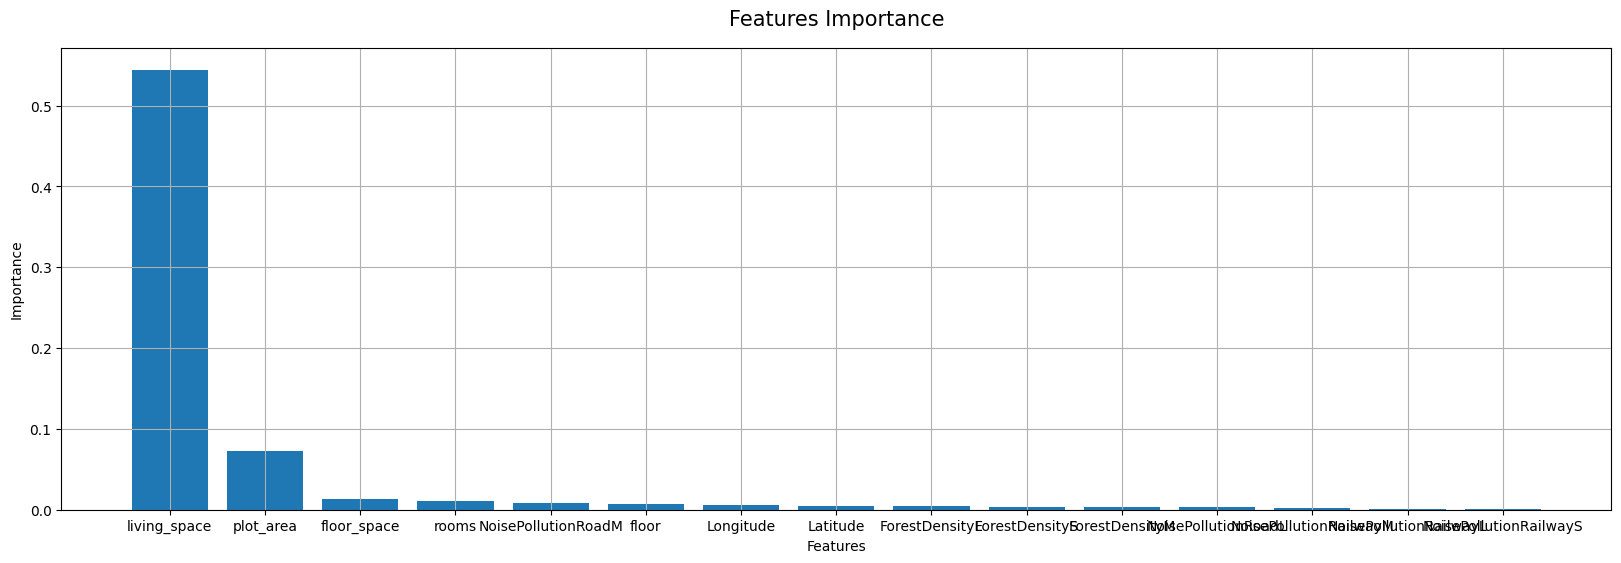

In [20]:
# create features importance list
decision_tree_feature_importance = list(
    zip(
        X_train.columns,
        decision_tree_regression.best_estimator_.feature_importances_[:15],
    )
)

# sort feature importance list
decision_tree_feature_importance.sort(key=lambda x: x[1], reverse=True)

# extract features into a list
decision_tree_features = [x[0] for x in decision_tree_feature_importance]

# plot the features importance
plt.figure(figsize=(20, 6))
plt.bar(*zip(*decision_tree_feature_importance))
plt.grid()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features Importance", fontsize=15, y=1.03)
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'poisson', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


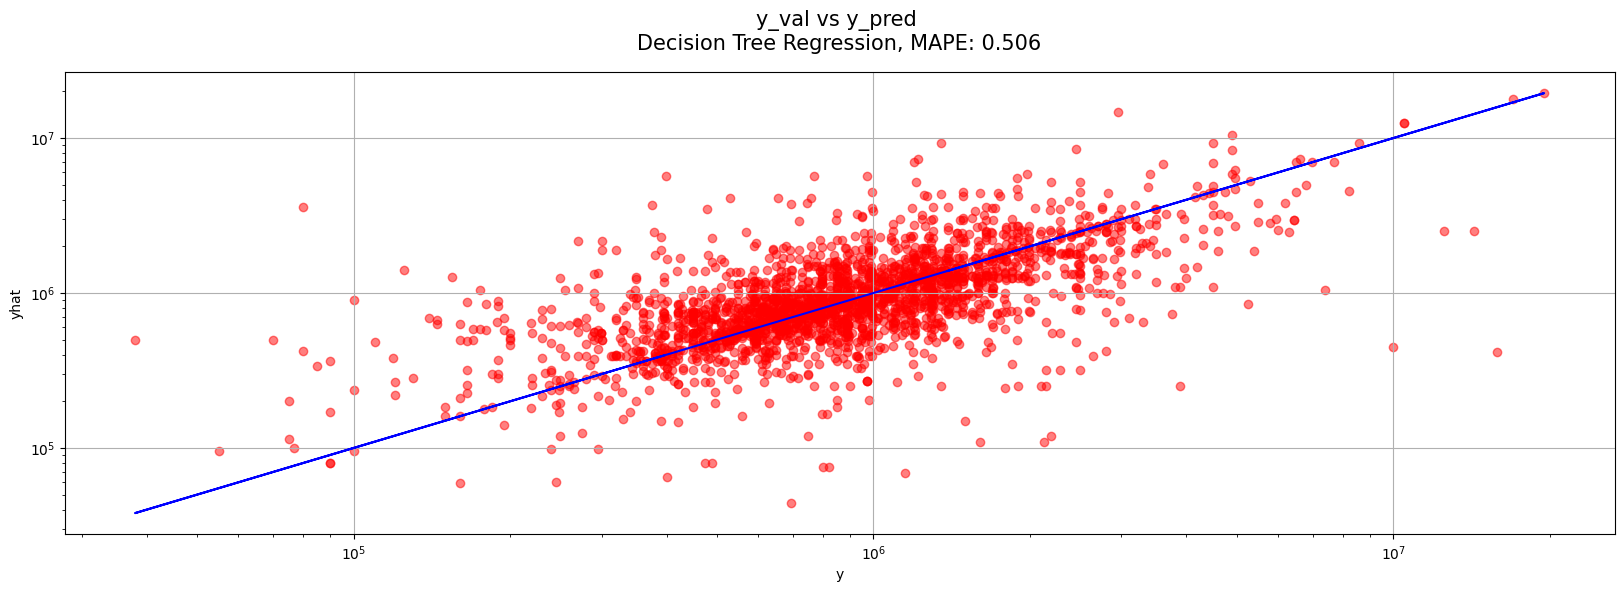

In [21]:
# call the function with best decision tree feautres
decision_tree_regression_reduced = decision_tree_regression_gridsearchCV(
    X_train[decision_tree_features],
    y_train,
    X_val[decision_tree_features],
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}


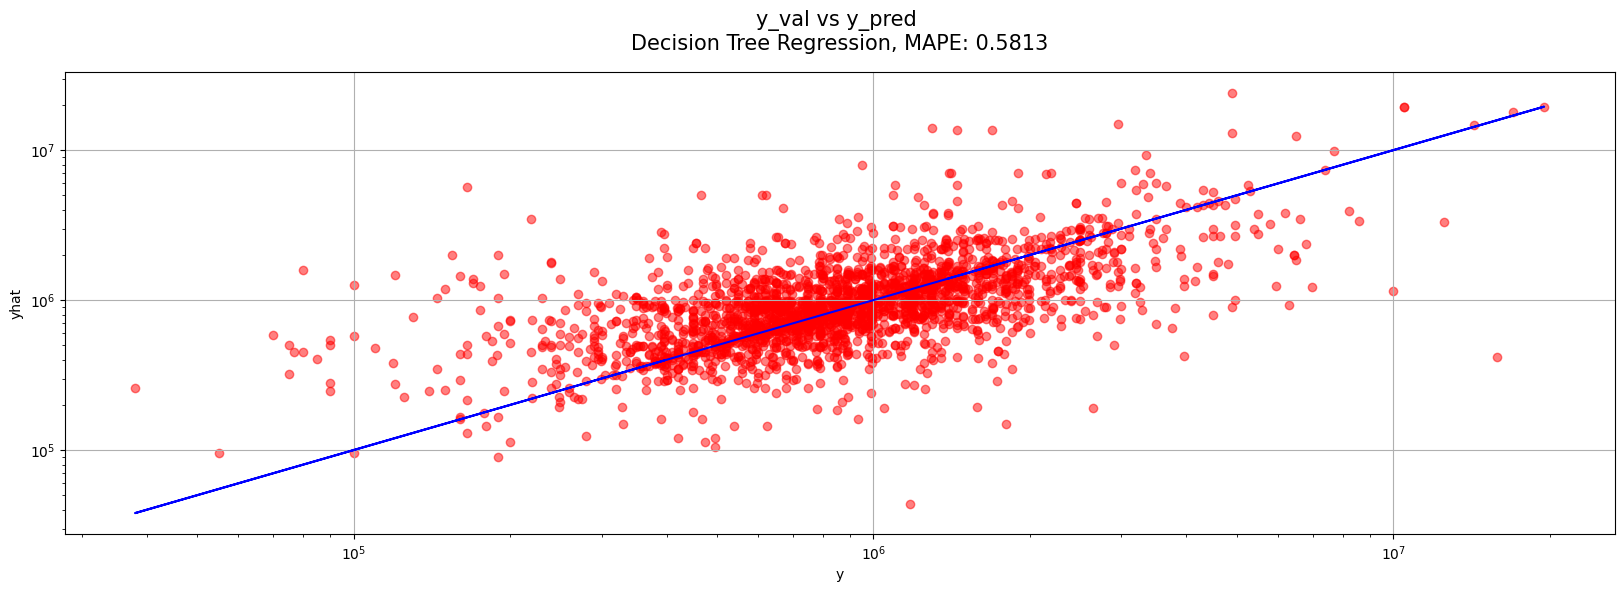

In [22]:
# call the function with best decision tree feautres
decision_tree_regression_reduced_lasso = decision_tree_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


---

# Modell 7 - Random Forest Regression

Modell 7 ist ein Random Forest Modell.


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


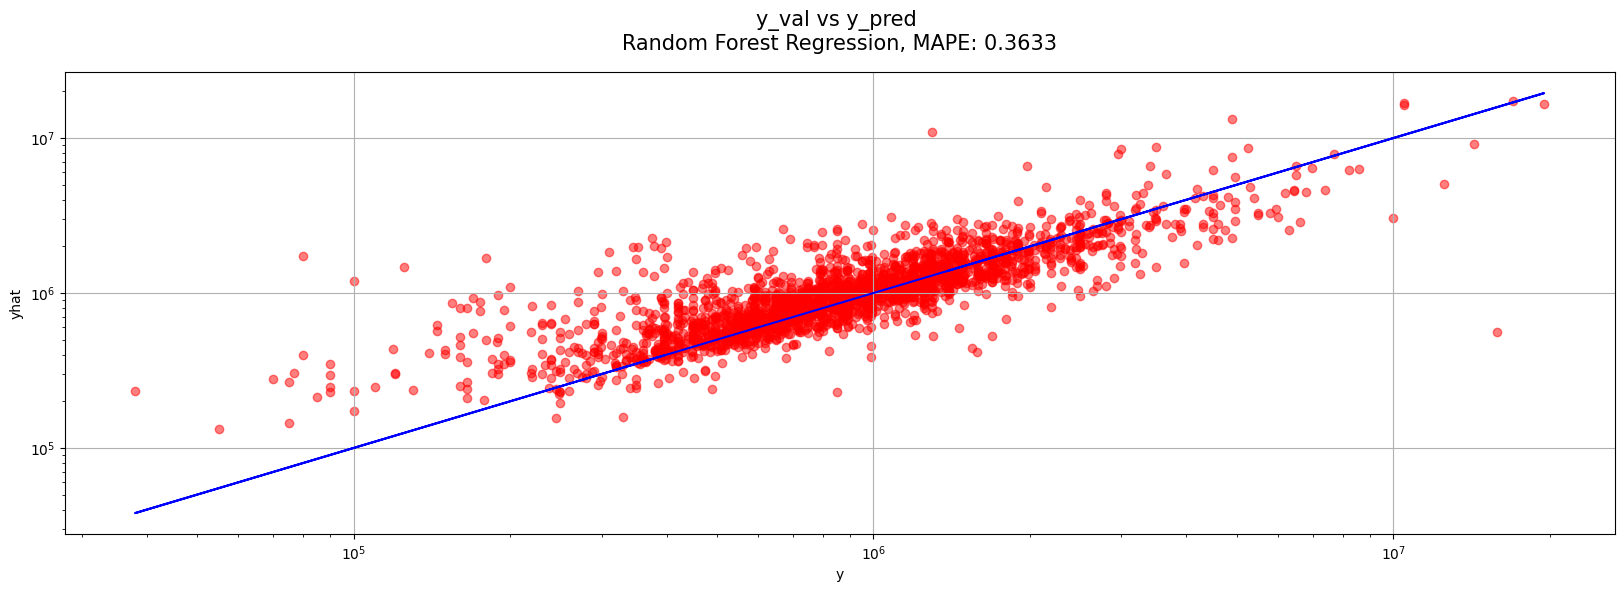

In [23]:
# make a random forest regression function with gridsearchCV
def random_forest_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_estimators=[100],
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a random forest regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    n_estimators : numpy array
        n_estimators for the random forest regression.
    max_depth : numpy array
        max_depth for the random forest regression.
    min_samples_split : numpy array
        min_samples_split for the random forest regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the random forest regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best random forest regression fitted model
    """
    # create random forest Modell with gridsearch cv
    random_forest = RandomForestRegressor()

    # create parameter grid
    param_grid = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        # "max_features": [None, "sqrt", "log2"],
        "max_features": [None],
        "random_state": [42],
    }

    # create gridsearchcv model
    random_forest_grid = GridSearchCV(
        random_forest,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    random_forest_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", random_forest_grid.best_params_)

    # predict the model
    y_pred_random_forest = random_forest_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_random_forest = mean_absolute_percentage_error(y_val, y_pred_random_forest)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_random_forest, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nRandom Forest Regression, MAPE: "
        + str(np.round(mape_random_forest, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return random_forest_grid


# call the function
random_forest_regression = random_forest_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


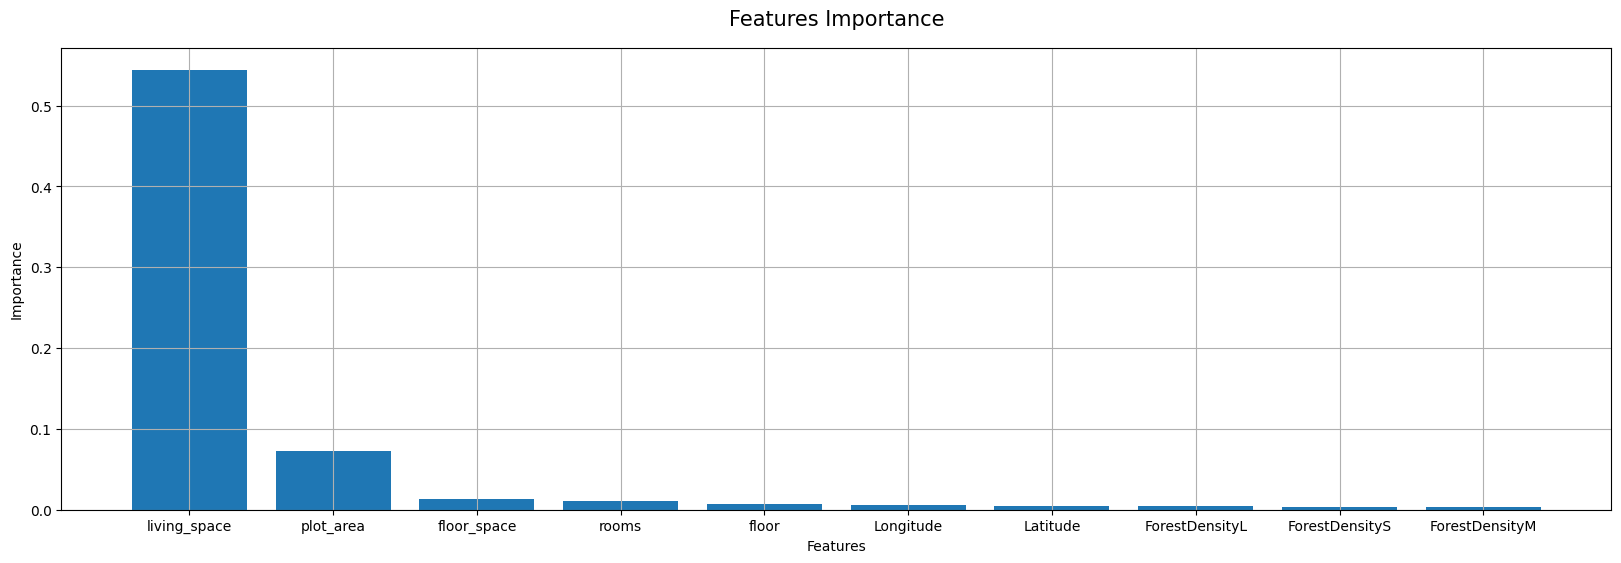

In [24]:
# create features importance list
random_forest_feautre_importance = list(
    zip(
        X_train.columns,
        decision_tree_regression.best_estimator_.feature_importances_[:10],
    )
)

# sort feature importance list
random_forest_feautre_importance.sort(key=lambda x: x[1], reverse=True)

# extract features into a list
random_forest_features = [x[0] for x in random_forest_feautre_importance]

# plot the features importance
plt.figure(figsize=(20, 6))
plt.bar(*zip(*random_forest_feautre_importance))
plt.grid()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features Importance", fontsize=15, y=1.03)
plt.show()


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


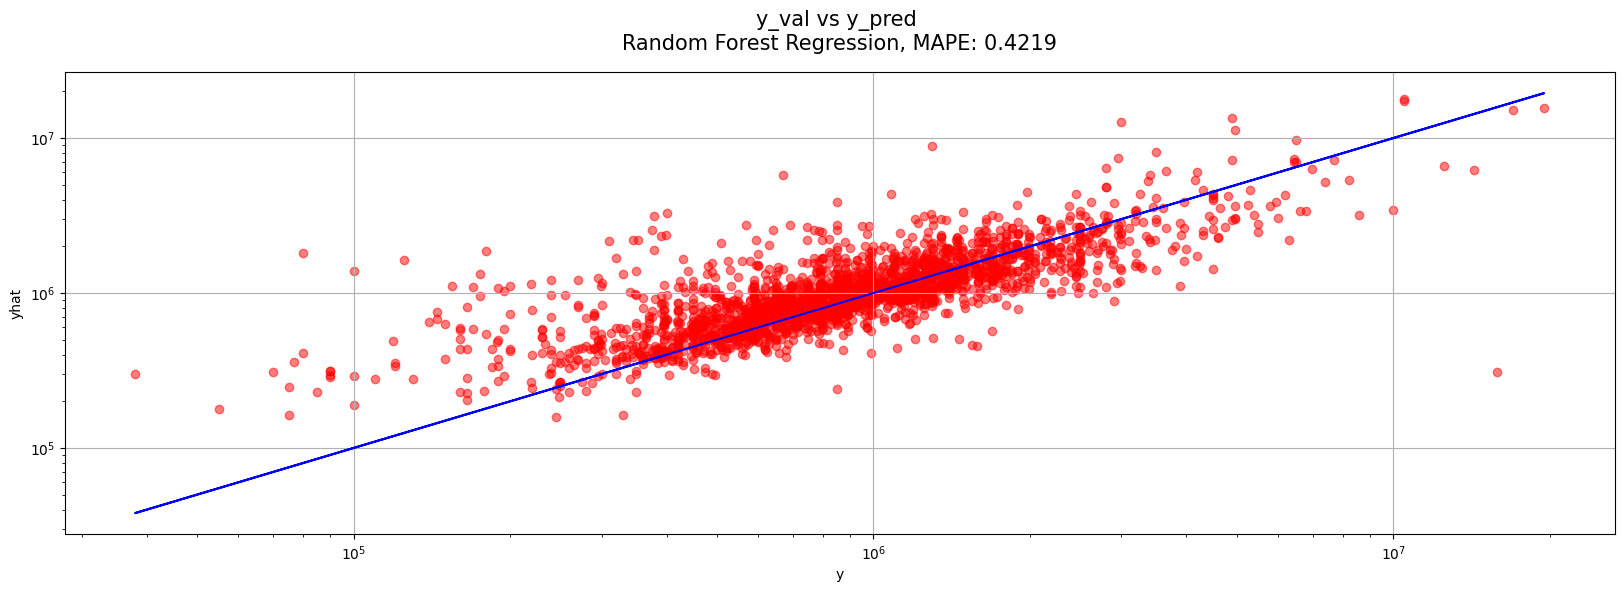

In [25]:
# call the function with random forest features
random_forest_regression_reduced = random_forest_regression_gridsearchCV(
    X_train[random_forest_features],
    y_train,
    X_val[random_forest_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


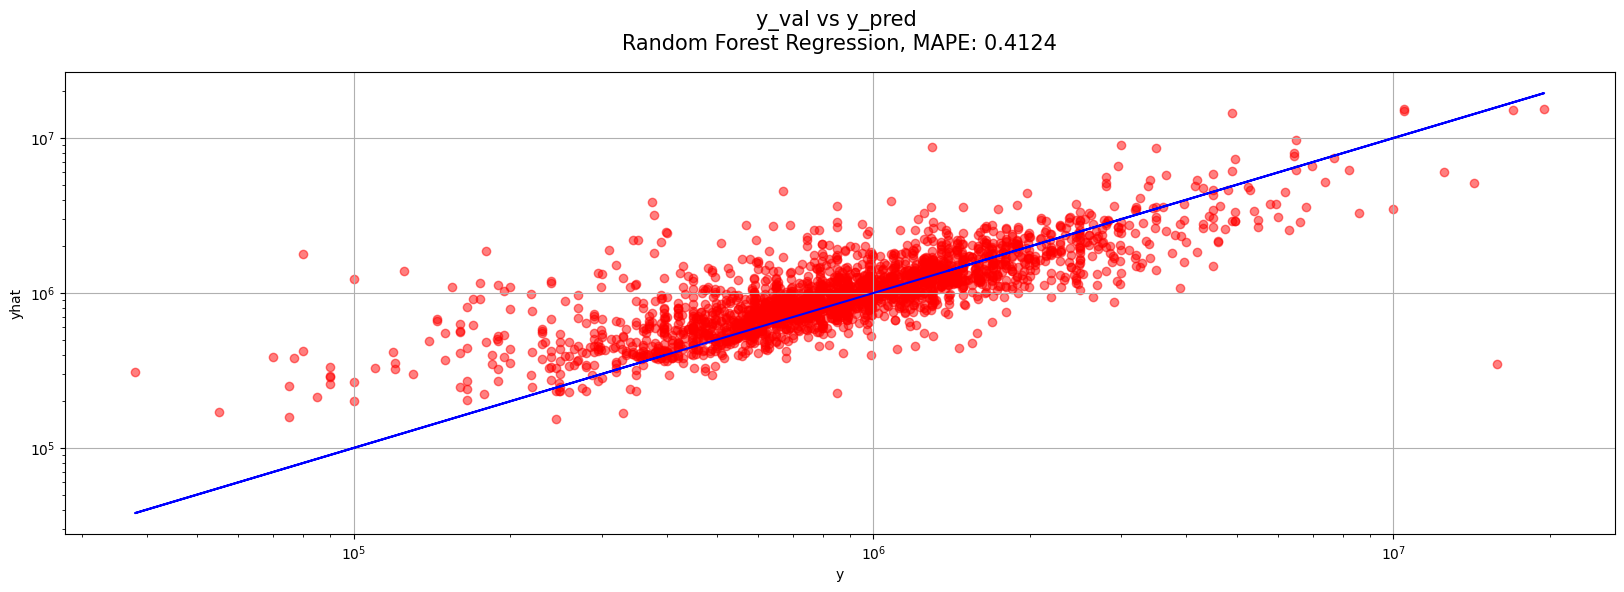

In [26]:
# call the function with decision tree features
random_forest_regression_reduced_tree = random_forest_regression_gridsearchCV(
    X_train[decision_tree_features],
    y_train,
    X_val[decision_tree_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


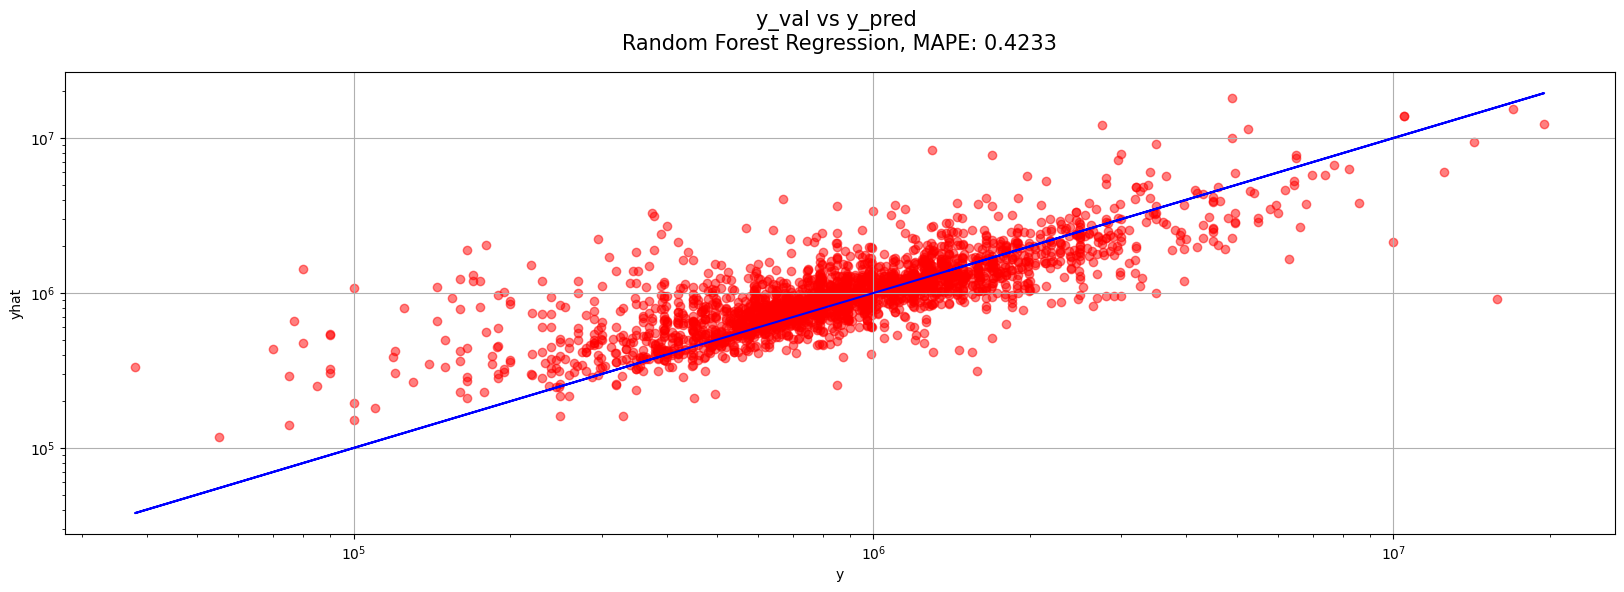

In [27]:
# call the function with lasso features
random_forest_regression_reduced_lasso = random_forest_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


---

# Modell 8 - Gradient Boosting Regression

Modell 8 ist ein Gradient Boosting Modell.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


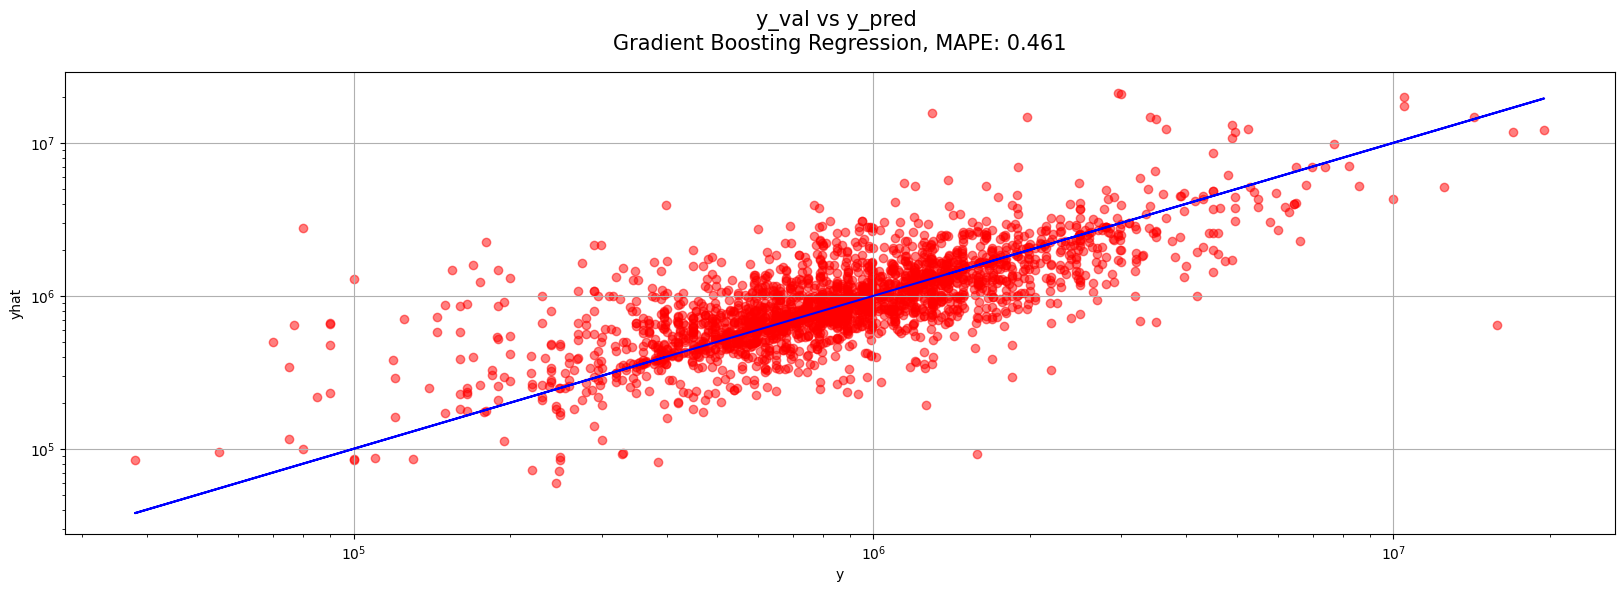

In [28]:
# make a gradient boosting regression function with gridsearchCV
def gradient_boosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    n_estimators=[100],
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a gradient boosting regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the gradient boosting regression.
    n_estimators : numpy array
        n_estimators for the gradient boosting regression.
    max_depth : numpy array
        max_depth for the gradient boosting regression.
    min_samples_split : numpy array
        min_samples_split for the gradient boosting regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the gradient boosting regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best gradient boosting regression fitted model
    """
    # create gradient boosting Modell with gridsearch cv
    gradient_boosting = GradientBoostingRegressor()

    # create parameter grid
    param_grid = {  # "loss": ["squared_error", "absolute_error", "huber", "quantile"],
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        # "criterion": ["friedman_mse", "mse", "mae"],
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "max_features": ["auto", "sqrt", "log2"],
        "random_state": [42],
        # alpha for quantile and huber
        # "alpha": np.linspace(0, 0.9, 4)
    }

    # create gridsearchcv model
    gradient_boosting_grid = GridSearchCV(
        gradient_boosting,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    gradient_boosting_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", gradient_boosting_grid.best_params_)

    # predict the model
    y_pred_gradient_boosting = gradient_boosting_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_gradient_boosting = mean_absolute_percentage_error(
        y_val, y_pred_gradient_boosting
    )

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_gradient_boosting, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nGradient Boosting Regression, MAPE: "
        + str(np.round(mape_gradient_boosting, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return gradient_boosting_grid


# call the function
gradient_boosting_regression = gradient_boosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # learning_rate = np.linspace(0.1, 1, 2, dtype=int),
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=5,
    verbose=1,
)


---

# Modell 9 - XGBoost Regression

Modell 9 ist ein XGBoost Modell.


Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'random_state': 42}


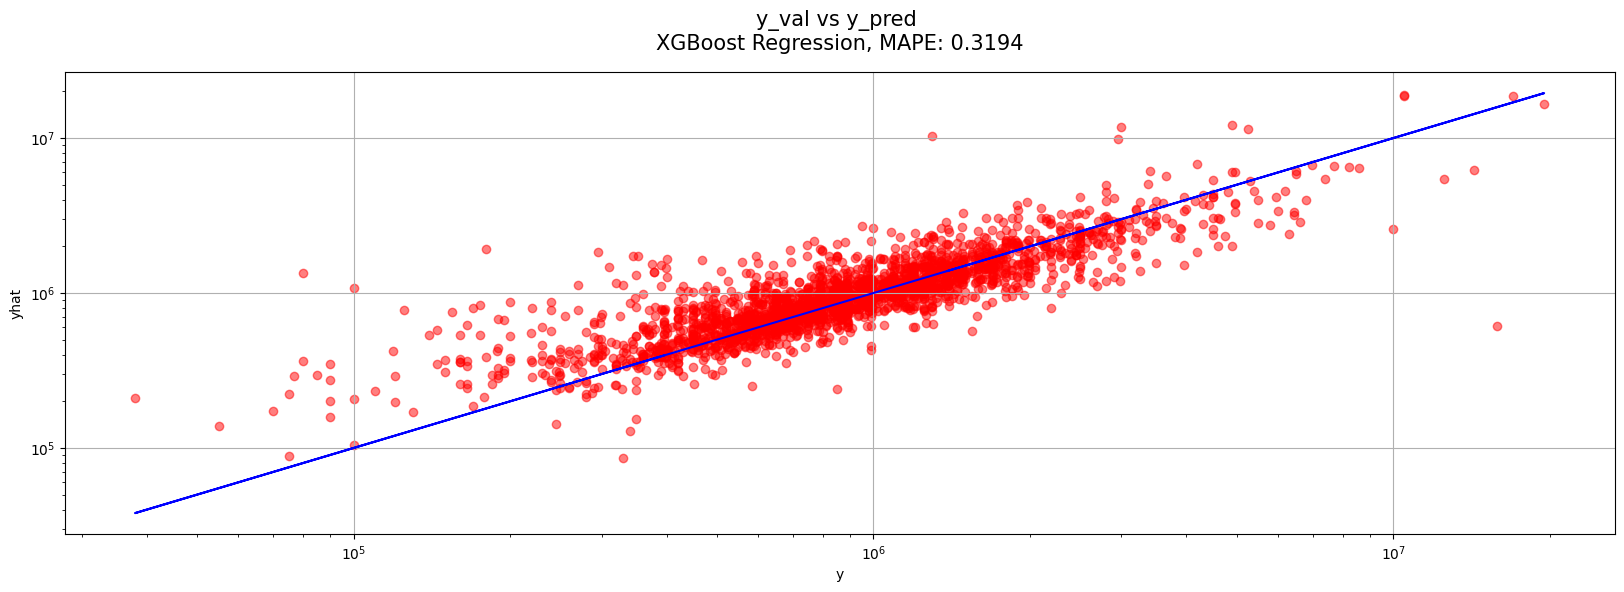

In [29]:
# make a xgboost regression function with gridsearchCV
def xgboost_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    max_depth=[6],
    cv=5,
    verbose=1,
):
    """
    This function makes a xgboost regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the xgboost regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best xgboost regression fitted model
    """
    # create xgboost Modell with gridsearch cv
    xgboost = XGBRegressor()

    # create parameter grid
    param_grid = {
        "learning_rate": learning_rate,
        "random_state": [42],
        "booster": ["gbtree"],
        "max_depth": max_depth,
    }

    # create gridsearchcv model
    xgboost_grid = GridSearchCV(
        xgboost,
        param_grid,
        cv=cv,
        n_jobs=-1,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    xgboost_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", xgboost_grid.best_params_)
    # predict the model
    y_pred_xgboost = xgboost_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_xgboost = mean_absolute_percentage_error(y_val, y_pred_xgboost)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_xgboost, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nXGBoost Regression, MAPE: " + str(np.round(mape_xgboost, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return xgboost_grid


# call the function
xgboost_regression = xgboost_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=4,
    learning_rate=[0.1],
    max_depth=[10, 15, 20],
    verbose=1,
)


---

# Modell 10 - Histgradientboosting Regression (log transformation)

Modell 10 ist ein Histgradientboosting Modell.


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 18, 'max_leaf_nodes': None, 'random_state': 42}


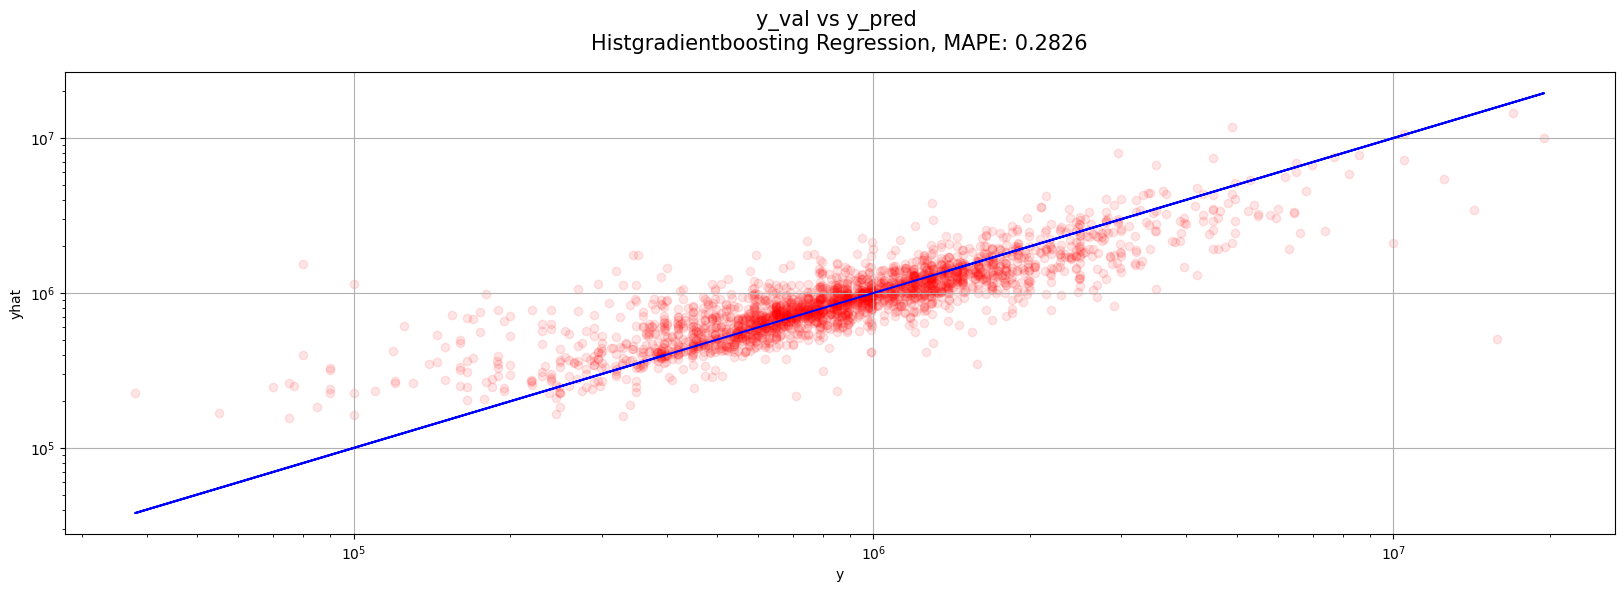

In [30]:
# make a histgradientboosting regression function with gridsearchCV
def histgradientboosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    max_depth=[6],
    cv=5,
    verbose=1,
):
    """
    This function makes a histgradientboosting regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the histgradientboosting regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best histgradientboosting regression fitted model
    """
    # create histgradientboosting Modell with gridsearch cv
    histgradientboosting = HistGradientBoostingRegressor()

    # create parameter grid
    param_grid = {
        "loss": ["absolute_error"],
        "learning_rate": learning_rate,
        "random_state": [42],
        "max_depth": max_depth,
        "max_leaf_nodes": [None],
        # "l2_regularization": [0.01, 0.1, 1],
    }

    # create gridsearchcv model
    histgradientboosting_grid = GridSearchCV(
        histgradientboosting,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    histgradientboosting_grid.fit(X_train, np.log(y_train))

    # print the best parameters
    print("Best parameters:", histgradientboosting_grid.best_params_)
    # predict the model
    y_pred_histgradientboosting = histgradientboosting_grid.predict(X_val)
    y_pred_histgradientboosting = np.exp(y_pred_histgradientboosting)

    # print the mean absolute percentage error
    mape_histgradientboosting = mean_absolute_percentage_error(
        y_val, y_pred_histgradientboosting
    )

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_histgradientboosting, c="red", alpha=0.1)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nHistgradientboosting Regression, MAPE: "
        + str(np.round(mape_histgradientboosting, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return histgradientboosting_grid


# call the function
histgradientboosting_regression = histgradientboosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=4,
    learning_rate=[0.1],
    max_depth=np.linspace(10, 20, 10, dtype=int),
    verbose=1,
)


---

# Vergleiche der Modelle

Hier werden die Modelle miteinander verglichen und tabellerisch sowie visualisiert dargestellt.
Dabei dient das Modell 1 - Multiple Linear Model, als Benchmark.


,Model,MAPE
8,HistGradientBoosting Regression,0.282566
7,XGBoost Regression,0.319358
6,RandomForest Regression,0.363315
4,KNeighbors Regression,0.394996
5,DecisionTree Regression,0.454366
1,Lasso Regression,0.51792
3,ElasticNet Regression,0.51792
0,Linear Regression,0.527305
2,Ridge Regression,0.527759


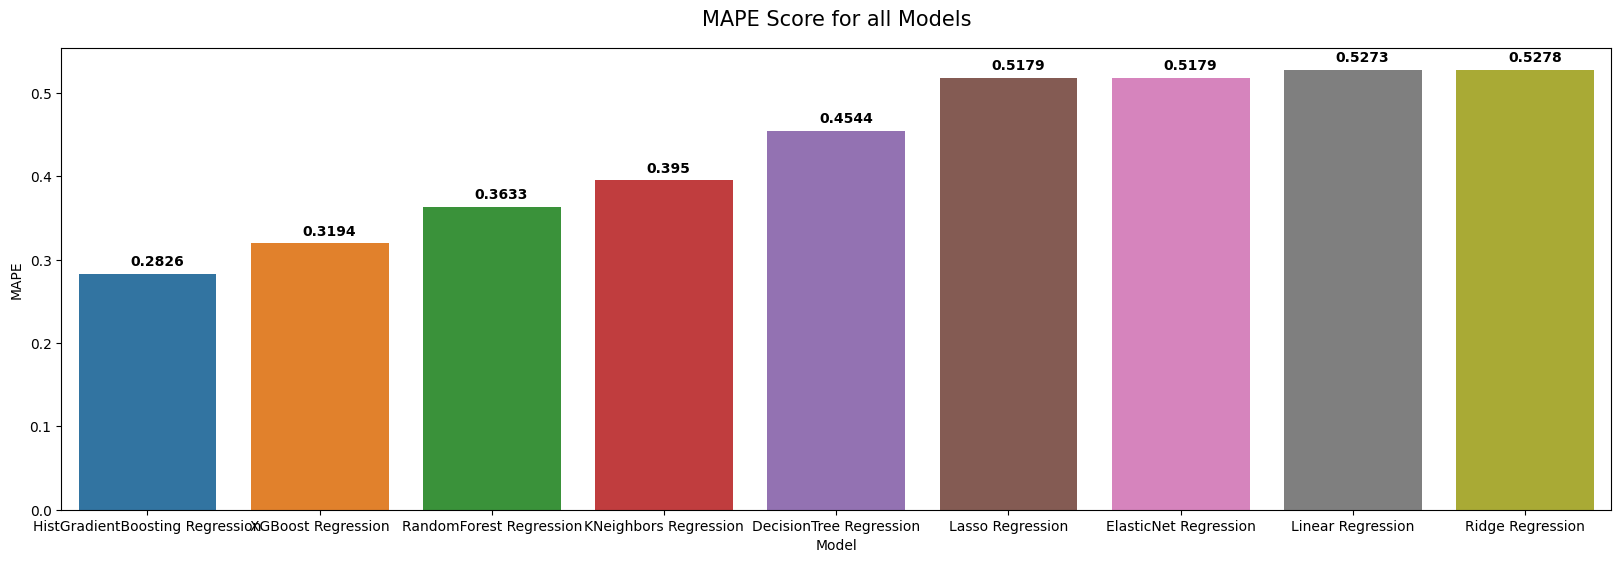

In [31]:
# create a dictionary for all models and their MAPE score

models = {
    "Linear Regression": linear_regression,
    "Lasso Regression": lasso_regression,
    "Ridge Regression": ridge_regression,
    "ElasticNet Regression": elastic_net_regression,
    "KNeighbors Regression": knn_regression,
    "DecisionTree Regression": decision_tree_regression,
    "RandomForest Regression": random_forest_regression,
    "XGBoost Regression": xgboost_regression,
    "HistGradientBoosting Regression": histgradientboosting_regression,
}

# create a dataframe for all models and their MAPE score
df_models = pd.DataFrame(columns=["Model", "MAPE"], index=range(len(models)))

# fill the dataframe with the models and their MAPE score
for i, model in enumerate(models):
    df_models.loc[i, "Model"] = model
    df_models.loc[i, "MAPE"] = mean_absolute_percentage_error(
        y_val, models[model].predict(X_val)
    )

df_models.loc[8, "MAPE"] = mean_absolute_percentage_error(
    y_val, np.exp(models["HistGradientBoosting Regression"].predict(X_val))
)

# sort dataframe by MAPE score
df_models = df_models.sort_values(by="MAPE", ascending=True)

# display dataframe
display(df_models)

# create a barplot for all models and their MAPE score on top of the bars
plt.figure(figsize=(20, 6))
sns.barplot(x="Model", y="MAPE", data=df_models)
for i, v in enumerate(df_models["MAPE"]):
    plt.text(
        i - 0.1,
        v + 0.01,
        str(np.round(v, 4)),
        color="black",
        fontweight="bold",
    )

plt.title("MAPE Score for all Models", fontsize=15, y=1.03)
plt.xlabel("Model")
plt.ylabel("MAPE")
plt.show()


---

# Untersuchung der "Variable Importance" für das beste Modell

Hier untersuchen wir die "Variable Importance" für das beste Modell.
Es hat sich herausgestellt, dass die .....


In [32]:
# CODE


---

# Predict Kaggle Data


In [33]:
predictions = pd.DataFrame(
    {
        "Id": X_kaggle.index,
        "Expected": np.exp(histgradientboosting_regression.predict(X_kaggle)),
    }
)

predictions.to_csv("predictions.csv", index=False)


---

# Fazit

Hier schreiben wir unser Fazit.
